In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# I. Table de données brutes 

#### Dans cette étape, on va fusionner les deux bases de données (celle d'apprentissage et celle de test), afin d'étudier les données dans leur ensemble (nous mettrons en place plusieurs techniques d'apprentissage par la suite, en distinguant bien ces deux bases, pour avoir le modèle le plus performant possible).

In [2]:
train = pd.read_csv("mower_market_datasets/mower_market_snapshot.csv", sep=";")

In [3]:
prod = pd.read_csv("mower_market_datasets/submission_set.csv", sep=";")

In [4]:
#Merging des bases de train et de test pour étudier les données dans leur ensemble.
data=pd.concat([train,prod])
#data=data.reset_index().set_index('id')

In [5]:
data.columns

Index([u'attractiveness', u'capacity', u'failure_rate', u'id', u'margin',
       u'market_share', u'price', u'prod_cost', u'product_type', u'quality',
       u'warranty'],
      dtype='object')

La première question que nous pouvons nous poser concerne la taille du dataset, et le type des colonnes. Ce dataset contient 1399 tondeuses, caractérisées par onze variables. Une variable est numérique discrète (int64), six sont numériques continues (float64), les autres sont encodées sour forme de texte (object). Ces informations ne préjugent pas du type des variables : quantitative, catégorielle, texte libre...

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1399 entries, 0 to 1398
Data columns (total 11 columns):
capacity          1399 non-null float64
failure_rate      1399 non-null float64
id                1399 non-null int64
margin            1399 non-null float64
price             1399 non-null float64
prod_cost         1381 non-null object
product_type      1399 non-null object
quality           1399 non-null object
warranty          1399 non-null object
market_share      1399 non-null float64
attractiveness    1399 non-null float64
dtypes: float64(6), int64(1), object(4)
memory usage: 120.3+ KB


Néanmoins, il est prudent de préter attention aux données numériques qui peuvent tout aussi bien être catégorielles si notamment à valeurs dans un espace discret.

In [7]:
#nombre de valeurs uniques pour les champs :
liste_var=['capacity','failure_rate','id','margin',
        'price','market_share','attractiveness']

for variable in liste_var:
    print('La variable numérique %s prend %s valeurs uniques.' %(variable,len(set(data[variable]))))

La variable numérique capacity prend 1999 valeurs uniques.
La variable numérique failure_rate prend 1999 valeurs uniques.
La variable numérique id prend 1999 valeurs uniques.
La variable numérique margin prend 1999 valeurs uniques.
La variable numérique price prend 1999 valeurs uniques.
La variable numérique market_share prend 1999 valeurs uniques.
La variable numérique attractiveness prend 1999 valeurs uniques.


# II. Analyse des données

À présent, faisons de la statistique descriptive basique sur nos donnnées (moyenne, écart-type, quartiles, etc). Nous remarquons que la tondeuse moyenne a une capacité de 47 litres, coûte 260 euros, qu'elle a un taux de panne moyen de 0.16 et dégagerait une marge de 186 euros.

In [8]:
train.describe()

,capacity,failure_rate,id,margin,price,market_share,attractiveness
count,1399.000000,1399.000000,1399.000000,1399.000000,1399.000000,1399.000000,1399.000000
mean,47.663266,0.166448,18958.000000,186.262609,260.075165,0.002144,0.636507
std,19.840501,0.073605,404.000825,191.011102,259.949127,0.001790,0.124016
min,0.013884,0.028906,18259.000000,52.943989,62.162200,0.000564,0.297384
25%,35.853890,0.095678,18608.500000,62.247602,73.379425,0.001135,0.549369
50%,50.309242,0.199796,18958.000000,66.299672,78.439753,0.001399,0.641351
75%,61.905015,0.228011,19307.500000,265.370973,384.265263,0.002446,0.726746
max,104.614865,0.302465,19657.000000,790.012898,964.973926,0.009314,0.952877


# III. Data visualisation 

Dans ce premier traitement, nous comptons le nombre de valeurs absentes pour chaque variable. Pandas interprète comme des NaN l'absence de valeurs. Énumérons ainsi l'ensemble des NaN pour chaque variable. Nous remarquons que la variable "prod_cost" contient 18 valeurs manquantes, d'autres variables sont absentes ("attractiveness" a exactement 600 valeurs absentes ; ce qui est logique puisqu'il s'agit des données à prédire, pareil pour "market_share").

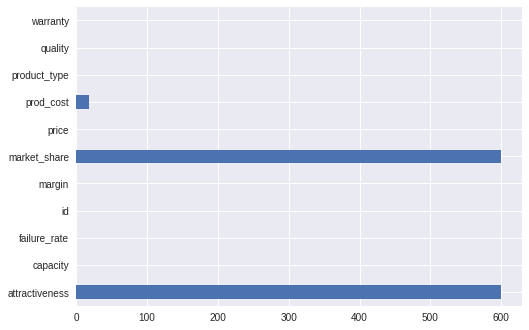

In [9]:
data.isnull().sum().plot(kind="barh")

Hors mi la variable "prod_cost", les données ne contiennent quasimment pas de valeurs nulles. 
Ce qui nous enlève déjà une épine du pied.

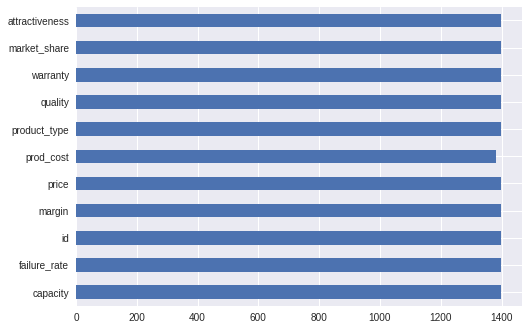

In [10]:
train.count().plot(kind="barh")

Dans notre cas les données de "prod" sont propres, pas de NaN, pas de modalités mal formatées etc.
Comme dans un contexte d'entreprise c'est très rarement le cas, on mettra en place un pipeline qui soit un minimum résilient face à ce genre de problématques.

## Etude de certains champs
On cherche à visulaliser simplement la distribution de certains champs 

"quality", "warranty", "product_type" et "margin"

On cherche à observer les valeurs les plus courantes

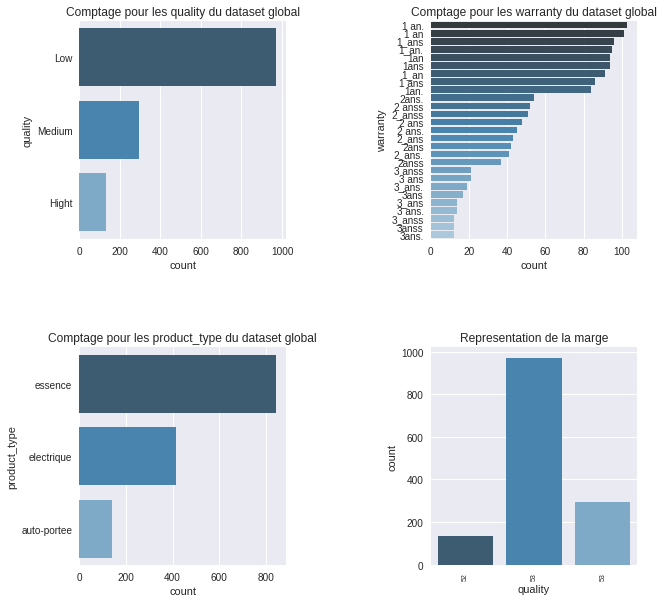

In [11]:
sns.set(style="darkgrid")
fig, axs = plt.subplots(2,2, figsize=(10, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.7)

axs=axs.ravel()

i=0
liste_champs=['quality','warranty','product_type']
for champs in liste_champs:
    a=sns.countplot(y=champs,
                   order=train[champs].value_counts().index,data=train,palette='Blues_d',ax=axs[i])
    a.set_title('Comptage pour les %s du dataset global' %(champs))
    i=i+1
    
a = sns.countplot(x="quality", order=train['quality'].value_counts().sort_index().index[0:40],data=train,palette='Blues_d',
                 ax=axs[3])
a.set_title('Representation de la marge')
l=[int(i) for i in list(train['margin'].value_counts().sort_index().index)]
#a.axes.get_xaxis().set_ticks(l[0:40:2])
a.set_xticklabels(l[0:40])
plt.setp(a.get_xticklabels(), fontsize=7, rotation='vertical')
a

- Pairgrid relations

On cherche à présenter les différentes relations entre variables numériques.

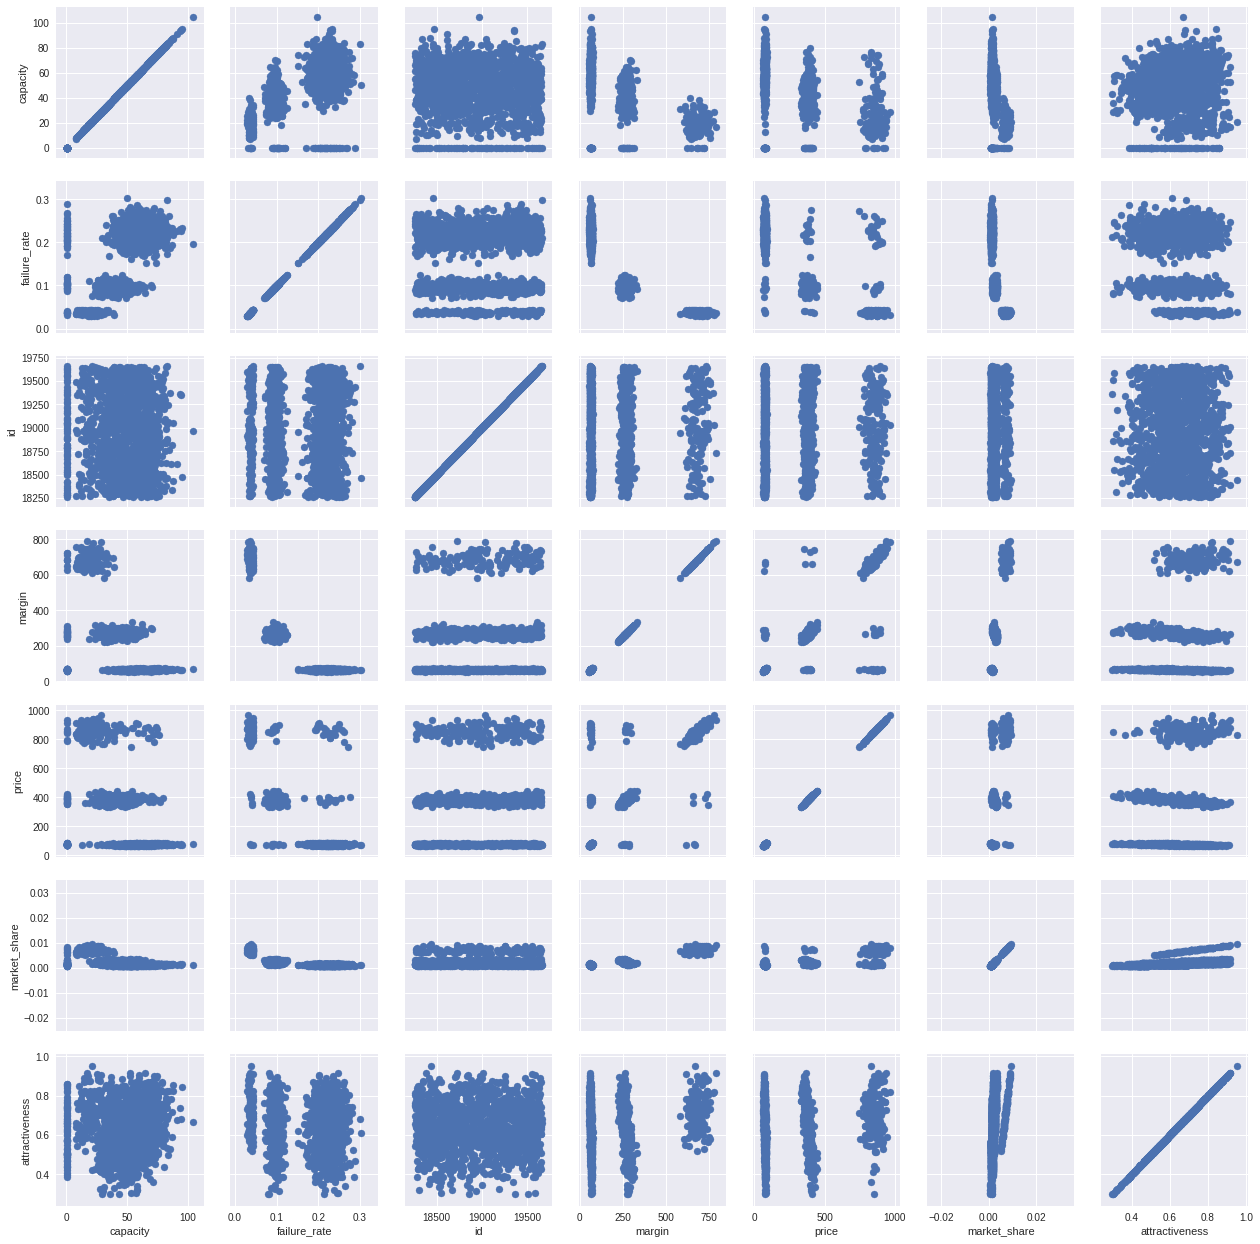

In [12]:
g = sns.PairGrid(train)
g.map(plt.scatter)

<b> Pas de relations linéaires qui se dégagent entre les variables.

- Matrice de corrélation

De façon plus lisible on cherche à visualiser les corrélations entre variables.

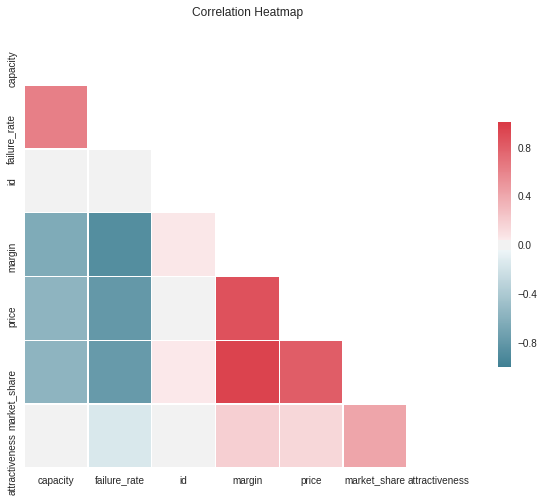

In [13]:
#Calcul de la matrice de corrélation
corr = train.corr()

#Mask pour la partie supérieur de la heatmap
#à de la symétrie de la matrice
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.set(style="white")

#Init
f, ax = plt.subplots(figsize=(10, 9))

#Generer une color map
cmap = sns.diverging_palette(220, 10, as_cmap=True)

#plot la matrice de correlation
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},ax=ax)
            #xticklabels=corr.columns, yticklabels=corr.columns,
ax.set_title('Correlation Heatmap')

<b>- Très forte corrélation positive entre la marge et le prix.

<b>- La cible à prédire c-à-d l'attractiveness est modérément corrélée positivement avec la marge et le prix  (puisque ces derniers vont de paire) et négativement corrélée avec le taux de panne.

<b>- L'id technique' ne semble être corrélé à aucune variable du dataset, ce qui est logique.

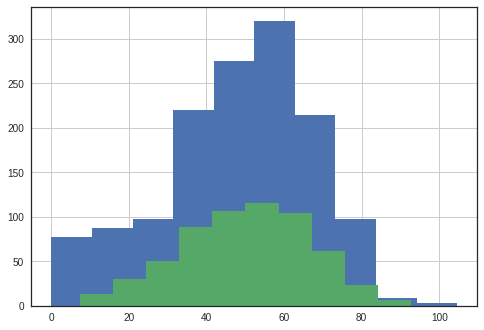

In [14]:
#fig, axs = plt.subplots(1,2)
train.capacity.hist(bins=10)
prod.capacity.hist(bins=10)

La distribution de la variable "capacity" est semblable sur les data set de train et de prod, il en est également de même pour les autres variables.

# IV. Gestion des données manquantes et des variables catégorielles

La variable "warranty" contient des données mal formatées, l'idée est donc de normaliser en fixant des modalités de réference, en l'occurence 1, 2 et 3 qui correspondent respectivement à 1 an, 2 ans et 3 ans.
NB: On appliquera les mêmes changements sur les données de "prod" pour être ISO.

In [15]:
data.warranty.value_counts()

1 an      456
2 ans     233
1 an.     103
1_ans      96
1_an.      95
1an        94
1ans       94
1_an       91
1 ans      86
1an.       84
3 ans      81
2ans.      54
2 anss     52
2_anss     51
2 ans.     45
2_ans      43
2ans       42
2_ans.     41
2anss      37
3 anss     21
3_ans.     19
3ans       17
3 ans.     14
3_ans      14
3_anss     12
3anss      12
3ans.      12
Name: warranty, dtype: int64

La variable "prod_cost" représente le coût de production et est cénsée être une variable quantitative continue.
Ainsi l'idée est de transformer les modalités "unknown" en valeurs nulles pour ensuite pouvoir les imputer.

In [16]:
train.prod_cost.value_counts()

0                     20
-64                   18
unknown               13
138.22724867280962     1
121.3167171267889      1
8.266586983283412      1
12.107481828856644     1
10.933183358482284     1
126.22298196541414     1
136.09227355119208     1
11.512823562500943     1
10.91631275377759      1
10.95931454374711      1
11.394834175948349     1
116.88769410044642     1
116.52955498915016     1
162.06122034931462     1
9.755177164057805      1
11.678049782822576     1
106.92550107378732     1
95.37390049789022      1
12.132259242980687     1
8.372005013545216      1
11.507333914069772     1
11.381958741921819     1
11.511371336816282     1
139.44611974434014     1
12.081637589945272     1
109.5714815298702      1
12.594031907573186     1
                      ..
10.57299720303393      1
115.47461004482957     1
9.875428908087356      1
11.62910239899752      1
153.43139149724738     1
13.281775240616417     1
10.728412300486093     1
115.58024359115775     1
11.471062726146465     1


Ci-dessous l'implémentation des deux classes permettant, respectivement, d'imputer les données nulles avec la valeur la plus fréquente en ce qui concerne les données catégorielles et puis la médiane pour les données continues.

In [17]:
from sklearn.base import TransformerMixin

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with median of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].median() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [18]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import preprocessing

class EncodeCategorical(BaseEstimator, TransformerMixin):
    """
    Encodes a specified list of columns or all columns if None.
    """

    def __init__(self, columns=None):
        self.columns  = columns
        self.encoders = None

    def fit(self, data, target=None):
        """
        Expects a data frame with named columns to encode.
        """
        # Encode all columns if columns is None
        if self.columns is None:
            self.columns = data.columns

        # Fit a label encoder for each column in the data frame
        self.encoders = {
            column: preprocessing.LabelEncoder().fit(data[column])
            for column in self.columns
        }
        return self

    def transform(self, data):
        """
        Uses the encoders to transform a data frame.
        """
        output = data.copy()
        for column, encoder in self.encoders.items():
            output[column] = encoder.transform(data[column])

        return output

In [19]:
train.attractiveness.describe()

count    1399.000000
mean        0.636507
std         0.124016
min         0.297384
25%         0.549369
50%         0.641351
75%         0.726746
max         0.952877
Name: attractiveness, dtype: float64

In [20]:
train.product_type.value_counts()

essence        844
electrique     413
auto-portee    142
Name: product_type, dtype: int64

In [21]:
train.prod_cost = pd.to_numeric(train.prod_cost, errors='coerce')

In [22]:
train.prod_cost.median()

12.141744573126562

In [23]:
prod.prod_cost.median()

12.666095171601789

# Gestion des données et modélisation

La fonction suivante combine les manipulations qui seront faites sur les données avant de les passer à notre pipeline sklearn

In [24]:
def data_management(df):
    ### Features engeneering
    ### Format warranty 
    df.warranty = df.warranty.map(lambda x: int(filter(str.isdigit, x)))
    
    ### Convert prod_cost to numeric, transform errors into NaN values
    df.prod_cost = pd.to_numeric(df.prod_cost, errors='coerce')
    
    ### Get estimator X & y
    df = df.set_index('id')
    features_df = df.drop(df[['attractiveness','market_share']], axis=1)
    target = df['attractiveness']
    return features_df, target

In [70]:
X, y = data_management(train.copy())

Avant d'entamer la modélisation, il est nécessaire de définir notre métrique d'évaluation 

In [25]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# rmsle root-mean-square-logarithmic error
def rmsle(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    return np.sqrt(mean_squared_error(np.log(y_true+1), np.log(y_pred+1)))

Echantillonage des données en train et test sets en fixant un état de Random figé.

In [35]:
from sklearn.cross_validation import train_test_split 
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42)

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

def create_pipeline(rg):  
   
    X_categorical_features = X.loc[:, X.dtypes == object]
    # build the pipeline
    return Pipeline([
            ('encoder',  EncodeCategorical(X_categorical_features.keys())),
            ('imputer', DataFrameImputer()),
            #('classifier', RandomForestRegressor(n_estimators=200,  max_depth=8))
            #('classifier', LinearRegression())
            ('regressor', rg)
        ])




## A. Méthode Linéaire
Approche la plus naïve

In [37]:
lr = LinearRegression()

In [38]:
pipe_lr = create_pipeline(lr)

In [39]:
# fit the pipeline
pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('encoder', EncodeCategorical(columns=Index([u'product_type', u'quality'], dtype='object'))), ('imputer', <__main__.DataFrameImputer object at 0x7f595417dc50>), ('regressor', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [40]:
y_pred = pipe_lr.predict(X_test)

In [42]:
%%time
print ("RMSLE error is: " + str(rmsle(y_test, y_pred)))

RMSLE error is: 0.076326258515
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 2.82 ms


In [71]:
pd.DataFrame(zip(X_train.columns, lr.coef_), columns=['features', 'estimated coefficients'])

,features,estimated coefficients
0,capacity,0.001851
1,failure_rate,0.586499
2,margin,-0.000157
3,price,-0.000045
4,prod_cost,-0.000439
5,product_type,-0.112589
6,quality,0.008356
7,warranty,0.112589


Le taux de panne impacte assez positivement la cible. Constat assez imprévu sur lequel on reviendra par la suite.

## B. Méthodes non-linéaires : méthodes ensemblistes
Ici, nous allons faire usage de méthodes non-linéaires d'apprentissage automatique, et nous verrons quelle est la meilleure méthode en termes de performances (notamment en termes de taux d'erreur et de vitesse d'exécution).

In [99]:
from sklearn.ensemble import RandomForestRegressor, RandomForestRegressor, GradientBoostingRegressor 
from sklearn.cross_validation import KFold
from sklearn.externals import joblib
from sklearn.metrics import mean_squared_error
import xgboost

In [101]:
%%time
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=300, max_depth=7, n_jobs=-1, max_features=None,criterion='mse',
                               min_samples_split=5,random_state=42)
pipe_rf = create_pipeline(rf)
# fit the pipeline
pipe_rf.fit(X_train, y_train)
y_pred = pipe_rf.predict(X_test)
y_sub = pipe_rf.predict(X_test)
print ("RMSLE error is: " + str(rmsle(y_test, y_pred)))

RMSLE error is: 0.0485440724118
CPU times: user 1.83 s, sys: 0 ns, total: 1.83 s
Wall time: 2.59 s


- GridSearch et Cross Validation

In [53]:
%%time
rf = RandomForestRegressor(criterion='mse', max_features=None,random_state=42)
n_estimators = [50, 100, 150, 200,300,400]
max_depth = [2, 4, 6, 8,10]
min_samples_split=[2,4,6,8]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators, min_samples_split=min_samples_split)
model = GridSearchCV(rf, param_grid, n_jobs=-1, cv=10,scoring='neg_mean_squared_error') #neg_mean_squared_error pour
                                                                                        #sklearn > 0.18
pipe_cv = create_pipeline(model)
# fit the pipeline
pipe_cv.fit(X_train, y_train)
y_pred = pipe_cv.predict(X_test)
print ("RMSLE error is: " + str(rmsle(y_test, y_pred)))

RMSLE error is: 0.0464112094496
CPU times: user 22min 8s, sys: 916 ms, total: 22min 9s
Wall time: 28min 45s


In [60]:
print("Meilleur model utilisant %s." % ( model.best_params_))

Meilleur model utilisant {'min_samples_split': 2, 'n_estimators': 400, 'max_depth': 10}.


Nous obtenons une RMSLE d'environ 0.046. L'erreur est très légèrement meilleure (entendre "plus faible") lorsque la profondeur est importante, néanmoins une grande profondeur tend à overfitter.

=> Clairement intéressant au vu du temps de traitement nécessaire.

In [56]:
%%time
from sklearn.ensemble import ExtraTreesRegressor

et = ExtraTreesRegressor(n_estimators=300, criterion='mse',max_depth=7,n_jobs=-1,
                         min_samples_split=5,max_features=None)

pipe_et = create_pipeline(et)
# fit the pipeline
pipe_et.fit(X_train, y_train)
y_pred = pipe_et.predict(X_test)
print ("RMSLE error is: " + str(rmsle(y_test, y_pred)))

RMSLE error is: 0.0557996381858
CPU times: user 1.2 s, sys: 4 ms, total: 1.2 s
Wall time: 2.02 s


- GridSearch et Cross Validation

In [58]:
%%time
et = ExtraTreesRegressor(criterion='mse',max_features=None)
n_estimators = [100, 150, 200,300,400]
max_depth = [4, 6, 8,10]
min_samples_split=[2,4,6,8]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators, min_samples_split=min_samples_split)
model_et = GridSearchCV(et, param_grid, n_jobs=-1, cv=10,scoring='neg_mean_squared_error')
pipe_et_cv = create_pipeline(model_et)
# fit the pipeline
pipe_et_cv.fit(X_train, y_train)
y_pred = pipe_et_cv.predict(X_test)
print ("RMSLE error is: " + str(rmsle(y_test, y_pred)))

RMSLE error is: 0.0483096193751
CPU times: user 13min 58s, sys: 340 ms, total: 13min 58s
Wall time: 18min 9s


Nous obtenons une RMSLE d'environ 0.048.

=> Résultat décevant également.

In [100]:
%%time
xgb = xgboost.XGBRegressor(max_depth=3, n_estimators=300, learning_rate=0.05)
pipe_xgb = create_pipeline(xgb)
# fit the pipeline
pipe_xgb.fit(X_train, y_train)
y_pred = pipe_xgb.predict(X_test)
print ("RMSLE error is: " + str(rmsle(y_test, y_pred)))

RMSLE error is: 0.044931157046
CPU times: user 200 ms, sys: 4 ms, total: 204 ms
Wall time: 458 ms


In [102]:
%%time
xg = xgboost.XGBRegressor(seed=42,nthread=-1)
n_estimators = [100, 150, 200,300,400]
max_depth = [3,4, 6, 8,10]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)
model_xg_cv = GridSearchCV(xg, param_grid, cv=10,scoring='neg_mean_squared_error') # n_jobs=-1,
pipe_xgb_cv = create_pipeline(model_xg_cv)
# fit the pipeline
pipe_xgb_cv.fit(X_train, y_train)
y_pred = pipe_xgb_cv.predict(X_test)
print ("RMSLE error is: " + str(rmsle(y_test, y_pred)))

RMSLE error is: 0.0449140727729
CPU times: user 55.8 s, sys: 60 ms, total: 55.9 s
Wall time: 1min 25s


=> Temps de traitement trop long comparé au gain minime en termes d'erreur.

### Modèle retenu:  Random Forest simple car meilleur rapport score/performance 

Pour terminer, il est toujours important d'étudier l'importance de nos variables dans le modèle. Cette étape permet de comprendre pourquoi il fonctionne et de l'expliquer à une population de non initiés! Grâce au paramètre feature_importances_ du regresseur nous allons voir quelles variables sont discriminantes pour la cible

In [104]:
pd.DataFrame(zip(X_train.columns, pipe_rf.named_steps['regressor'].feature_importances_), columns=['features', 'importance'])

,features,importance
0,capacity,0.189801
1,failure_rate,0.173993
2,margin,0.214307
3,price,0.299570
4,prod_cost,0.046381
5,product_type,0.005918
6,quality,0.063084
7,warranty,0.006947


## IV. Soumission des résultats

In [371]:
import os
def write_to_file(X_prod,y_pred,filename,path) :
    if not os.path.exists(path):
        os.makedirs(path)
    X_prod['attractiveness'] = y_pred
    X_prod[['attractiveness']].to_csv(path+filename, sep='|')
    print('Ecriture finie.')
    return

Apprentissage sur tout le data set afin de bénéficier de toute l'information disponible

In [384]:
pipe_rf.fit(X, y)

Pipeline(steps=[('encoder', EncodeCategorical(columns=Index([u'product_type', u'quality'], dtype='object'))), ('imputer', <__main__.DataFrameImputer object at 0x7f2d113ec450>), ('regressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           n_estimators=300, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False))])

In [385]:
df = prod.copy()
df.warranty = df.warranty.map(lambda x: int(filter(str.isdigit, x)))
df.prod_cost = pd.to_numeric(df.prod_cost, errors='coerce')
df = df.set_index('id')
y_pred = pipe_rf.predict(df)

In [386]:
#Ecriture
write_to_file(prod.copy(), y_pred,'ma_prediction.csv',path)

Ecriture finie.


### Il est également possible de sauvegarder le pipeline dans un fichier pour être ré-utilisé plus tard:
### Très pratique et même indispensable lorsqu'on veut industrialiser co

In [387]:
from sklearn.externals import joblib
joblib.dump(pipe_rf, 'my_model.pkl')

['my_model.pkl',
 'my_model.pkl_01.npy',
 'my_model.pkl_02.npy',
 'my_model.pkl_03.npy',
 'my_model.pkl_04.npy',
 'my_model.pkl_05.npy',
 'my_model.pkl_06.npy',
 'my_model.pkl_07.npy',
 'my_model.pkl_08.npy',
 'my_model.pkl_09.npy',
 'my_model.pkl_10.npy',
 'my_model.pkl_11.npy',
 'my_model.pkl_12.npy',
 'my_model.pkl_13.npy',
 'my_model.pkl_14.npy',
 'my_model.pkl_15.npy',
 'my_model.pkl_16.npy',
 'my_model.pkl_17.npy',
 'my_model.pkl_18.npy',
 'my_model.pkl_19.npy',
 'my_model.pkl_20.npy',
 'my_model.pkl_21.npy',
 'my_model.pkl_22.npy',
 'my_model.pkl_23.npy',
 'my_model.pkl_24.npy',
 'my_model.pkl_25.npy',
 'my_model.pkl_26.npy',
 'my_model.pkl_27.npy',
 'my_model.pkl_28.npy',
 'my_model.pkl_29.npy',
 'my_model.pkl_30.npy',
 'my_model.pkl_31.npy',
 'my_model.pkl_32.npy',
 'my_model.pkl_33.npy',
 'my_model.pkl_34.npy',
 'my_model.pkl_35.npy',
 'my_model.pkl_36.npy',
 'my_model.pkl_37.npy',
 'my_model.pkl_38.npy',
 'my_model.pkl_39.npy',
 'my_model.pkl_40.npy',
 'my_model.pkl_41.npy',